HW1은 과제를 수행함에 있어 모델 변경, 파라이터튜닝, 피처조정 등의 방법이 모두 허용됩니다.

In [8]:
import os
import email_read_util

In [9]:
%cd

C:\Users\jiyoo


## Download 2007 TREC Public Spam Corpus
1. Read the "Agreement for use"
   https://plg.uwaterloo.ca/~gvcormac/treccorpus07/

2. Download 255 MB Corpus (trec07p.tgz) and untar into the 'chapter1/datasets' directory

3. Check that the below paths for 'DATA_DIR' and 'LABELS_FILE' exist

In [10]:
DATA_DIR = 'C:/Users/jiyoo/Downloads/dataset/trec07p/trec07p/data/'
LABELS_FILE = 'C:/Users/jiyoo/Downloads/dataset/trec07p/trec07p/full/index'
TRAINING_SET_RATIO = 0.7

In [11]:
labels = {}
# Read the labels
with open(LABELS_FILE) as f:
    for line in f:
        line = line.strip()
        label, key = line.split()
        labels[key.split('/')[-1]] = 1 if label.lower() == 'ham' else 0

In [12]:
def read_email_files():
    X = []
    y = [] 
    for i in range(len(labels)):
        filename = 'inmail.' + str(i+1)
        email_str = email_read_util.extract_email_text(
            os.path.join(DATA_DIR, filename))
        X.append(email_str)
        y.append(labels[filename])
    return X, y

In [13]:
X, y = read_email_files()

In [14]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test, idx_train, idx_test = \
    train_test_split(X, y, range(len(y)), 
    train_size=TRAINING_SET_RATIO, random_state=2)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Initialize the classifier and make label predictions
mnb = MultinomialNB()
mnb.fit(X_train_vector, y_train)
y_pred = mnb.predict(X_test_vector)

# Print results
print(classification_report(y_test, y_pred, target_names=['Spam', 'Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

        Spam       0.99      0.94      0.97     15035
         Ham       0.90      0.98      0.94      7591

    accuracy                           0.96     22626
   macro avg       0.94      0.96      0.95     22626
weighted avg       0.96      0.96      0.96     22626

Classification accuracy 95.6%


# 0. 문제 정의
Ham이 precision이 0.9인데 recall이 0.98라는 의미는
ham이라고 진단한 것들 중에 진짜인 건 90%인 거고
진짜인 것들 중에서 ham이라고 진단이 내려진 것이 98%이라는 뜻이다. 

precision과 recall 둘 다 중요한 것은 맞지만 
Ham을 판별하는 분류기가 헷갈리면 그냥 Ham으로 분류해버려 recall을 높이는 방향으로 갔다고 해석할 수 있다.

Spam은 recall이 0.94인 것으로 보아 진짜 spam 중에 진단을 놓치는 애들이 있다는 것이다. 

헷갈리는 부분이 병목이다. 
헷갈리는 게 뭔지 알아야 그걸 Ham과 spam으로 정확하게 분류시킬 수 있을 것 같다. 

**Counter Vectorize + NaiveBayes모델이 Ham을 헷갈리게 되는 이유가 무엇일지 알아보자**

# 0. EDA

1. 문장으로 이루어진 data와 html 형식으로 (html 태그가 존재) 이루어진 data가 혼재되어있음. 
2. Duplicate된 text가 있음 (아예 내용이 모두 같음)
3. Re:, fwd 된 email은 반복되는 내용이 있음
4. [R] 이라는 software에 관한 이메일이 많음
5. URL이 http, https, www.로 시작하거나 ip로 이뤄진 형태로 다양함.
6. URL에 .gif가 있는 것은 spam일 확률이 높아보임. 

**가장 큰 요인은 
HTML 태그가 text를 추출하는 데에 방해된다는 점임.**

* vectorize시킬 때 counter로 하다보면 html 태그도 counter에 포함되어 막상 text의 '내용'으로 spam을 구분 못하게 될 수도 있음.
* 단순 vectorize보다 TF-IDF로 하는 점이 의미와 context를 반영하기에 성능 향상이 된다고 추측할 수 있다.

In [16]:
X_train[0]

'Re.Question <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<HTML><HEAD><TITLE></TITLE>\n</HEAD>\n<BODY>\n\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0px; margin-bottom: 0px;" align="center">\n<table style="border: 2px; border-style: solid; border-color:#000000; font-family: Tahoma; font-weight: bold;" cellpadding="15" cellspacing="0" bgcolor="#FF0000">\n<style>    * L&#246;sch-Aktion bei der Bundeswehr: Minister Jung k&#252;ndigt Aufkl&#228;rung an      Intelligenter Tintenfisch: Flaschen&#246;ffnen unter Wasser Video abspielen...bl&#228;ttern    * US- Leitzins: Notenbank h&#228;lt sich alle Optionen offen    * Energieversorgung: Vorteil Russland im Pipeline- Schach    * DepotMichael Timm ist der erfolgreichste deutsche Box-Coach. Er trainiert im Universum-Boxstall sieben Weltmeister - und Weltmeisterinnen. An diesem Wochenende k&#228;mpfen gleich drei seiner Sch&#252;tzlinge um Titel - der Prominentest

In [19]:
X_train[8]

'AccuWeather.com Alert Forecast <!doctype html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1" />\n<title>AccuWeather.com(R) Alert Daily Forecast</title>\n</head>\n<body>\n<div style="width:665px;margin:0px auto;font-family:arial,helvetica,verdana,sans-serif;">\n<table>\n<tr height="96">                                                                                                                                                                    \n   <td colspan="6">                                                                                                                                                                 \n      <img src="http://spotlight.accuweather.com/dyndoc/spotlight/QXA1750/alert/flasher.gif height="1" width="1" />                                                                

In [23]:
X_train[13]

'Avis Important et Personnel <html>\n\n<head>\n<title>Mouvement Desjardins</title>\n<style type="text/css">\n<!--\n.style1 {\n\tfont-family: Verdana, Arial, Helvetica, sans-serif;\n\tfont-size: 12px;\n}\n.style2 {\n\tfont-size: 14px;\n\tfont-weight: bold;\n}\n.style4 {font-size: 12px}\n-->\n</style>\n</head>\n<table width="777" border="0">\n  <tr>\n    <td width="17"> </td>\n    <td width="750"><TABLE width=750 border=1 align="right" cellPadding=0 cellSpacing=0 bordercolor="e1dcd0">\n      <TBODY>\n        <TR>\n          <TD width=750 bgcolor="efede6"><TABLE cellSpacing=0 cellPadding=0 width="100%" bgColor=#009966 border=0>\n              <TBODY>\n                <TR>\n                  <TD><IMG \nsrc="https://accesd.desjardins.com/public/0939/fr_CA_ACCESD/image/bandeau.gif"></TD>\n                </TR>\n              </TBODY>\n            </TABLE>\n              <P align="justify"><SPAN class=Estilo6><span class="style2"><FONT color=#009966> Cher(e) membre \n                Desjardin

In [24]:
X_train[12]

'Avis Important et Personnel <html>\n\n<head>\n<title>Mouvement Desjardins</title>\n<style type="text/css">\n<!--\n.style1 {\n\tfont-family: Verdana, Arial, Helvetica, sans-serif;\n\tfont-size: 12px;\n}\n.style2 {\n\tfont-size: 14px;\n\tfont-weight: bold;\n}\n.style4 {font-size: 12px}\n-->\n</style>\n</head>\n<table width="777" border="0">\n  <tr>\n    <td width="17"> </td>\n    <td width="750"><TABLE width=750 border=1 align="right" cellPadding=0 cellSpacing=0 bordercolor="e1dcd0">\n      <TBODY>\n        <TR>\n          <TD width=750 bgcolor="efede6"><TABLE cellSpacing=0 cellPadding=0 width="100%" bgColor=#009966 border=0>\n              <TBODY>\n                <TR>\n                  <TD><IMG \nsrc="https://accesd.desjardins.com/public/0939/fr_CA_ACCESD/image/bandeau.gif"></TD>\n                </TR>\n              </TBODY>\n            </TABLE>\n              <P align="justify"><SPAN class=Estilo6><span class="style2"><FONT color=#009966> Cher(e) membre \n                Desjardin

In [25]:
X_train[14]

'[R] Re : Help please for graphics! To whom it may concern,\n\nI want to plot two or more graphs in the same window by the means of the "plot "command. I have tried the option "add=TRUE" but this last does not work! Have you an hit for me please? \n\nThank you very much for your attention.\n\nBernard Colin\n\n\n\t[[alternative HTML version deleted]]\n\n______________________________________________\nR-help@stat.math.ethz.ch mailing list\nhttps://stat.ethz.ch/mailman/listinfo/r-help\nPLEASE do read the posting guide http://www.R-project.org/posting-guide.html\nand provide commented, minimal, self-contained, reproducible code.\n\n'

In [28]:
X_train[23]

'Re: TTSynth Is Here At Last Linux can understand gpt partition tables use bootcamp to install Linux if \nyou want.\n\n----- Original Message ----- \nFrom: "David Poehlman" <david.poehlman@handsontechnologeyes.com>\nTo: "Speakup is a screen review system for Linux." <speakup@braille.uwo.ca>\nSent: Saturday, June 09, 2007 3:20 AM\nSubject: Re: TTSynth Is Here At Last\n\n\n>I don\'t want to wipe the os though.\n>\n> ----- Original Message ----- \n> From: "Spie Smith" <bdsmith@buncombe.main.nc.us>\n> To: "Speakup is a screen review system for Linux." \n> <speakup@braille.uwo.ca>\n> Sent: Friday, June 08, 2007 3:17 PM\n> Subject: Re: TTSynth Is Here At Last\n>\n>\n> You should have no problem running Linux on a mac.  With the intel\n> chip in the new mac, just boot a live cd or install a conventional\n> distro and you should be on your way.  If the drivers for the mac\n> hardware are too different, though, from those for hardware under\n> x-86, you might encounter some trouble there.  I ha

In [31]:
X_train[26]

'[R] Netiquette etc {was "nls.control() has no influence on nls()!"} >>>>> "Joerg" == Joerg van den Hoff <j.van_den_hoff@fzd.de>\n>>>>>     on Mon, 16 Apr 2007 11:15:23 +0200 writes:\n\n    Joerg> On Mon, Apr 16, 2007 at 09:03:27AM +0200, Martin Maechler wrote:\n\n    >> >>>>> "Yuchen" == Yuchen Luo <realityrandom@gmail.com>\n\n [................]\n [................]\n\n\n    Joerg> a final remark (off-topic?), concerning the response\n    Joerg> of m. maechler (but I notice this attitude\n    Joerg> continously on the list): this is supposed to be a\n    Joerg> help list, neither a boot camp nor a thought-police\n    Joerg> school, right?.\n\nIn general, Joerg, you are entirely right, and I do behave like\nthat typically. \n\nNow, since you responded in public, I do too:\nWhat I did not like at all about Yuchen\'s posting was it\'s\nsubject which claims obvious misfunctioning, using a "!", not a\n"?" to make the point.  \nThe subject of an e-mail is the first and typically most read 

In [25]:
X_train[3]

'The Best for Your Health! '

In [17]:
X_train[10]

'Troubles with your penis?  Does Size Matter\'?\n----\n\n60% of WOMEN said thay were UNHAPPY with their lover"s P* size!\n\nIntroducing the Newest, Safest, and Most Advanced\nSolution in Pnis En1argment, Anywhere!\n\nMillions of men are already applying male enhan(ement pat(hes daily and watching their\nsize and drive go through the roof! P,atches deliver the product into your system in a quicker\nand more efficient manner than a pi11 ever could. They are also safer and more discrete!\n\nUnreal p,rice dis(ounts we are offering for a 1imited time only!\n\nhttp://www.renat.hk/ - Go here now and Get it!\n\n----\nFlack leaned forward. Very slowly he removed the debris of the cigar f\nI came further into the room without invitation. An open love-pulp mag\n"How is the old boy? I haven\'t seen him since that time I fell off the\n\n'

In [50]:
y_train

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,


In [23]:
print("len(X_train):",len(X_train))
print("len(X_test):",len(X_test))

len(X_train): 52793
len(X_test): 22626


# 1. Text 기반 : Vectorize

## 1-1. TF-IDF

* counter vectorize 식의 성능 저해 요소가 HTML 태그가 text를 추출하는 데에 방해된다는 점이었는데, vectorize시킬 때 counter로 하다보면 html 태그도 counter에 포함되어 막상 text의 '내용'으로 spam을 구분 못하게 될 수도 있기 때문이다.
* 단순 vectorize보다 **TF-IDF로 하는 vectorize 방식이** **Spam 문서에서의 특정 단어의 중요도를 반영하기에 Ham을 덜 헷갈리게 하여 성능 향상이 된다고 추측할 수 있다.**

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer()
X_train_vector=vectorizer.fit_transform(X_train)
X_test_vector=vectorizer.transform(X_test)

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

mnb=MultinomialNB()
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.98      0.98      0.98     15035
         Ham       0.96      0.97      0.96      7591

    accuracy                           0.97     22626
   macro avg       0.97      0.97      0.97     22626
weighted avg       0.97      0.97      0.97     22626

Classification accuracy 97.3%


## 1-2. (성능개선 실패) MultinomialNB의 parameter 조정
MultinomialNB에 대한 설명 (text word vector tf-idf에 쓰임)
=Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [37]:
#class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#기본값
mnb=MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=False, class_prior=None)
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.99      0.94      0.97     15035
         Ham       0.90      0.98      0.94      7591

    accuracy                           0.96     22626
   macro avg       0.94      0.96      0.95     22626
weighted avg       0.96      0.96      0.96     22626

Classification accuracy 95.7%


In [38]:
#class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#parameter: force_alpha를 False로 바꿔봄. 
mnb=MultinomialNB(alpha=1.0, force_alpha=False, fit_prior=True, class_prior=None)
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.98      0.98      0.98     15035
         Ham       0.96      0.97      0.96      7591

    accuracy                           0.97     22626
   macro avg       0.97      0.97      0.97     22626
weighted avg       0.97      0.97      0.97     22626

Classification accuracy 97.3%


In [39]:
#class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#alpha를 0.1에서 force_alpha를 False로 바꿈
mnb=MultinomialNB(alpha=0.1, force_alpha=False, fit_prior=True, class_prior=None)
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.99      0.97      0.98     15035
         Ham       0.94      0.98      0.96      7591

    accuracy                           0.97     22626
   macro avg       0.96      0.97      0.97     22626
weighted avg       0.97      0.97      0.97     22626

Classification accuracy 97.1%


In [40]:
#class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#alpha를 0.1에서 force_alpha를 True로 바꿔봄 -> 변화 X
mnb=MultinomialNB(alpha=0.1, force_alpha=True, fit_prior=True, class_prior=None)
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.99      0.97      0.98     15035
         Ham       0.94      0.98      0.96      7591

    accuracy                           0.97     22626
   macro avg       0.96      0.97      0.97     22626
weighted avg       0.97      0.97      0.97     22626

Classification accuracy 97.1%


In [43]:
#class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#alpha를 최소값으로 바꿔봄. 성능 차이가 심하게 있지는 않다.
mnb=MultinomialNB(alpha=1e-10, force_alpha=True, fit_prior=True, class_prior=None)
mnb.fit(X_train_vector,y_train)
y_pred=mnb.predict(X_test_vector)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.99      0.96      0.97     15035
         Ham       0.92      0.98      0.95      7591

    accuracy                           0.97     22626
   macro avg       0.96      0.97      0.96     22626
weighted avg       0.97      0.97      0.97     22626

Classification accuracy 96.6%


## 1-2. TF-IDF가 아닌 Word2Vec model로 vectorize하기
### Text preprocessing : BeautifulSoup이 갑자기 작동이 안되어 HTML 태그 제거가 안됨 -> 소문자 변환, tokenize정도로 간단히

In [9]:
pip install gensim #word2vec을 위해 NLP 자연어 처리용 gensim package 다운

  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.7.0 from https://files.pythonhosted.org/packages/65/76/903324159e4a3566e518c558aeb21571d642f781d842d8dd0fd9c6b0645a/scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 59.0/59.0 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for numpy>=1.18.5 from https://files.pythonhosted.org/packages/d8/ec/ebef2f7d7c28503f958f0f8b992e7ce606fb74f9e891199329d5f5f87404/numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependen

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.


### 1-2-1. (성능 개선 실패) 분류 모델: Logistic Regression

In [20]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def vectorize_text(text_tokens, model):
    # Word2Vec model에 token으로 맞추기 위해서 word vector를 average해줌. 
    vector = np.zeros(model.vector_size)
    count = 0
    
    for token in text_tokens:
        if token in model.wv:
            vector += model.wv[token]
            count += 1
    
    if count > 0:
        vector /= count
    
    return vector

# Dataset 입력
emails = X
labels = y  # 1: spam, 0: ham

# Preprocess된 데이터를 Tokenize
tokenized_emails = [email.lower().split() for email in emails]  # 소문자로 변환해서 tokenize

# Word2Vec model로 train
word2vec_model = Word2Vec(sentences=tokenized_emails, vector_size=100, window=5, min_count=1, workers=4)

# Raw email data를 word2vec model로 Vectorize 하기
vectorized_emails = np.array([vectorize_text(email, word2vec_model) for email in tokenized_emails])

# X,y를 일괄 변환시켜주고 이 시점에서 split해주기
X_train2, X_test2, y_train2, y_test2, idx_train2, idx_test2 = \
    train_test_split(vectorized_emails, labels, range(len(labels)), 
    train_size=TRAINING_SET_RATIO, random_state=2)

# Logistic Regression으로 분류
classifier = LogisticRegression()
classifier.fit(X_train2, y_train2)

predictions = classifier.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, predictions))
print("Classification Report:\n", classification_report(y_test2, predictions))


Accuracy: 0.9451073985680191
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     15035
           1       0.93      0.90      0.92      7591

    accuracy                           0.95     22626
   macro avg       0.94      0.93      0.94     22626
weighted avg       0.94      0.95      0.94     22626



C:\Users\jiyoo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 1-2-2. (성능 개선 성공) 분류 모델: Stacking 기법으로 다수의 분류기를 혼합해서 사용
### 1) random forest, 2) AdaBoost, 3) GaussianNB, 4) XGBoost, 5) LightGBM 모두 사용

In [22]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

def vectorize_text(text_tokens, model):
    vector = np.zeros(model.vector_size)
    count = 0
    
    for token in text_tokens:
        if token in model.wv:
            vector += model.wv[token]
            count += 1
    
    if count > 0:
        vector /= count
    
    return vector

emails = X
labels = y  

tokenized_emails = [email.lower().split() for email in emails] 

word2vec_model = Word2Vec(sentences=tokenized_emails, vector_size=100, window=5, min_count=1, workers=4)

vectorized_emails = np.array([vectorize_text(email, word2vec_model) for email in tokenized_emails])

X_train2, X_test2, y_train2, y_test2, idx_train2, idx_test2 = \
    train_test_split(vectorized_emails, labels, range(len(labels)), 
    train_size=TRAINING_SET_RATIO, random_state=2)

#base learner로 random forest, adaboost, gaussianNB, xgboost, lightGBM를 모두 사용
#n_estimator는 임의로 100으로 선정
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('ab', AdaBoostClassifier(n_estimators=100)),
    ('nb', GaussianNB()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier())
]

# Stacking Classifier로 작동
stack_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=5)

# Train
stack_clf.fit(X_train2, y_train2)

predictions = stack_clf.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, predictions))
print("Classification Report:\n", classification_report(y_test2, predictions))


C:\Users\jiyoo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jiyoo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 17629, number of negative: 35164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 52793, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333927 -> initscore=-0.690478
[LightGBM] [Info] Start training from score -0.690478
[LightGBM] [Info] Number of positive: 14103, number of negative: 28131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 42234, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333925 -> initscore=-0.690485
[LightGBM] [Info] Start training from score -0.690485
[LightGB

# 2. 번외) 성능 개선 실패 : Feature 추출 후 ML (Decision Tree) 분류

## 2-1. Feature Extraction : one-hot encoding
EDA를 기반으로 Feature를 임의로 선정함
1. data에 수신인이 존재하는지? 0,1
2. data에 발신인 sender의 domain이 존재하는지? 0,1
3. data의 총 text 길이
4. url이 존재하는가? 0,1
5. dataset 내에 같은 발신인이 보낸 카운트 수 (같은 발신인이 여러 개를 보냈을 때)
6. data가 html 형식인지 그냥 문장인지? 0,1
7. dataset 내에 똑같은 내용의 중복된 data가 있다면 카운트 수
8. Re: 로 시작하는지? 0,1
9. [R]이라는 소프트웨어에 관한 메일인지? 0,1
10. text에 gif를 포함하고 있는지? 0,1
11. URL이 https인지? 0,1
12. URL이 http인지? 0,1
13. URL이 www.인지? 0,1

In [32]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from collections import Counter

def extract_sender_domain(email_content):
   #sender domain 텍스트에서 추출하기
    match = re.search(r'From:.*?\[mailto:(.*?)\]', email_content)
    if match:
        return match.group(1).split('@')[-1]
    return None

def classify_frequency(domain, domain_counts):
    #sender domain의 frequency 카운트
    count = domain_counts.get(domain, 0)
    return count

def extract_features(row, domain_counts, content_counts):
    """ Extracts specified features from the email HTML content in DataFrame row. """
    soup = BeautifulSoup(row['email_content'], 'html.parser')
    text = soup.get_text(strip=True)
    sender_domain = extract_sender_domain(row['email_content'])
    html_format = 1 if bool(BeautifulSoup(row['email_content'], "html.parser").find()) else 0
    starts_with_re = 1 if re.search(r'^Re:', row['email_content'], re.IGNORECASE) else 0

    url_matches = re.findall(r'http://\S+|https://\S+|www.', row['email_content'])
    if url_matches:
        # https, http, www를 각자 다른 feature로 사용-> 처음 나오는 URL로 추출
        https_vs_http_no = 1 if url_matches[0].startswith('https://') else 0
        http_vs_https_no= 1 if url_matches[0].startswith('http://') else 0 
        www_vs_https_http_no=1 if url_matches[0].startswith('www.') else 0
    else:
        https_vs_http_no=0
        http_vs_https_no=0
        www_vs_https_http_no = 0

    features = {
        'receiver_exist': 1 if 'To:' in text else 0,
        'sender_domain': 1 if sender_domain else 0,
        'text_size': len(text),
        'url_present': 1 if url_matches else 0,
        'frequency': classify_frequency(sender_domain, domain_counts) if sender_domain else 0,
        'is_html': html_format,
        'duplicate_content': content_counts[row['email_content']],
        'starts_with_re': starts_with_re,
        'contains_r': 1 if '[R]' in text else 0,
        'contains_gif': 1 if '.gif' in row['email_content'] else 0,
        'https_vs_http': https_vs_http_no,
        'http_vs_https_no' : http_vs_https_no,
        'www_vs_https_http_no':www_vs_https_http_no
    }

    return pd.Series(features)

df = pd.DataFrame({
    'email_content':X_train  
})

domain_counts = Counter(df['email_content'].apply(extract_sender_domain).dropna())
content_counts = Counter(df['email_content'])

 #각 행마다 적용(feature extraction)
feature_df5 = df.apply(extract_features, axis=1, args=(domain_counts, content_counts))
print(feature_df5)


C:\Users\jiyoo\AppData\Local\Temp\ipykernel_17568\1742820202.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(row['email_content'], 'html.parser')
C:\Users\jiyoo\AppData\Local\Temp\ipykernel_17568\1742820202.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  html_format = 1 if bool(BeautifulSoup(row['email_content'], "html.parser").find()) else 0
C:\Users\jiyoo\AppData\Local\Temp\ipykernel_17568\1742820202.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(row['email_content'], 'html.parser')
C:\Users\jiyoo\AppData\Local\Temp\ipykernel_17568\1742820202.py:23: MarkupResemblesLocatorWarning: The input look

In [32]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from collections import Counter
from datetime import datetime

def extract_sender_domain(email_content):
       #sender domain 텍스트에서 추출하기
    match = re.search(r'From:.*?\[mailto:(.*?)\]', email_content)
    if match:
        return match.group(1).split('@')[-1]
    return None

def classify_frequency(domain, domain_counts):
    count = domain_counts.get(domain, 0)
    return count

def extract_features(row, domain_counts, content_counts):
    soup = BeautifulSoup(row['email_content'], 'html.parser')
    text = soup.get_text(strip=True)
    sender_domain = extract_sender_domain(row['email_content'])
    html_format = 1 if bool(BeautifulSoup(row['email_content'], "html.parser").find()) else 0
    starts_with_re = 1 if re.search(r'^Re:', row['email_content'], re.IGNORECASE) else 0

    #URL에 http, https, www.가 있으면 있다고 1, 없으면 0
    url_matches = re.findall(r'http://\S+|https://\S+|www.', row['email_content'])
    if url_matches:
        # https, http, www를 각자 다른 feature로 사용 -> 처음 나오는 URL로 추출
        https_vs_http_no = 1 if url_matches[0].startswith('https://') else 0
        http_vs_https_no= 1 if url_matches[0].startswith('http://') else 0 
        www_vs_https_http_no=1 if url_matches[0].startswith('www.') else 0
    else:
        https_vs_http_no=0
        http_vs_https_no=0
        www_vs_https_http_no = 0

    features = {
        'receiver_exist': 1 if 'To:' in text else 0,
        'sender_domain': 1 if sender_domain else 0,
        'text_size': len(text),
        'url_present': 1 if url_matches else 0,
        'frequency': classify_frequency(sender_domain, domain_counts) if sender_domain else 0,
        'is_html': html_format,
        'duplicate_content': content_counts[row['email_content']],
        'starts_with_re': starts_with_re,
        'contains_r': 1 if '[R]' in text else 0,
        'contains_gif': 1 if '.gif' in row['email_content'] else 0,
        'https_vs_http': https_vs_http_no,
        'http_vs_https_no' : http_vs_https_no,
        'www_vs_https_http_no':www_vs_https_http_no
    }

    return pd.Series(features)


df = pd.DataFrame({
    'email_content':X_test 
})

#domain frequency와 content frequency 카운트
domain_counts = Counter(df['email_content'].apply(extract_sender_domain).dropna())
content_counts = Counter(df['email_content'])

# 각 행마다 적용(feature extraction)
test_feature_df5 = df.apply(extract_features, axis=1, args=(domain_counts, content_counts))
print(test_feature_df5)


C:\Users\jiyoo\AppData\Local\Temp\ipykernel_1644\1879282359.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(row['email_content'], 'html.parser')
C:\Users\jiyoo\AppData\Local\Temp\ipykernel_1644\1879282359.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  html_format = 1 if bool(BeautifulSoup(row['email_content'], "html.parser").find()) else 0
C:\Users\jiyoo\anaconda3\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml packag

       receiver_exist  sender_domain  text_size  url_present  frequency  \
0                   0              0        589            1          0   
1                   1              0       1650            1          0   
2                   0              0         42            0          0   
3                   0              0          7            0          0   
4                   0              0        594            1          0   
...               ...            ...        ...          ...        ...   
22621               0              0       2941            0          0   
22622               0              0        582            1          0   
22623               0              0         17            0          0   
22624               0              0         16            0          0   
22625               0              0         40            0          0   

       is_html  duplicate_content  starts_with_re  contains_r  contains_gif  \
0            0      

In [31]:
feature_df5.describe()

,receiver_exist,sender_domain,text_size,url_present,frequency,is_html,duplicate_content,starts_with_re,contains_r,contains_gif,https_vs_http,http_vs_https_no,www_vs_https_http_no
count,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000,52793.000000
mean,0.020950,0.003978,995.032334,0.475480,0.087853,0.251511,102.065975,0.211108,0.087928,0.100638,0.099009,0.363931,0.011649
std,0.143217,0.062945,4090.507574,0.499403,1.942384,0.433885,361.166176,0.408098,0.283193,0.300852,0.298677,0.481134,0.107302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,252.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1220.000000,1.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,672001.000000,1.000000,54.000000,1.000000,1775.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


1775번이나 duplicate된 text가 있음

In [33]:
feature_df5[feature_df5['duplicate_content']==1775]

,receiver_exist,sender_domain,text_size,url_present,frequency,is_html,duplicate_content,starts_with_re,contains_r,contains_gif,https_vs_http,http_vs_https_no,www_vs_https_http_no
12,0,0,1869,1,0,1,1775,0,0,1,1,0,0
13,0,0,1869,1,0,1,1775,0,0,1,1,0,0
16,0,0,1869,1,0,1,1775,0,0,1,1,0,0
20,0,0,1869,1,0,1,1775,0,0,1,1,0,0
27,0,0,1869,1,0,1,1775,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52652,0,0,1869,1,0,1,1775,0,0,1,1,0,0
52660,0,0,1869,1,0,1,1775,0,0,1,1,0,0
52666,0,0,1869,1,0,1,1775,0,0,1,1,0,0
52692,0,0,1869,1,0,1,1775,0,0,1,1,0,0


반복되는 text는 Avis Important et .... 으로 시작하는 text, spam으로 분류됨.

In [210]:
X_train[13]

'Avis Important et Personnel <html>\n\n<head>\n<title>Mouvement Desjardins</title>\n<style type="text/css">\n<!--\n.style1 {\n\tfont-family: Verdana, Arial, Helvetica, sans-serif;\n\tfont-size: 12px;\n}\n.style2 {\n\tfont-size: 14px;\n\tfont-weight: bold;\n}\n.style4 {font-size: 12px}\n-->\n</style>\n</head>\n<table width="777" border="0">\n  <tr>\n    <td width="17"> </td>\n    <td width="750"><TABLE width=750 border=1 align="right" cellPadding=0 cellSpacing=0 bordercolor="e1dcd0">\n      <TBODY>\n        <TR>\n          <TD width=750 bgcolor="efede6"><TABLE cellSpacing=0 cellPadding=0 width="100%" bgColor=#009966 border=0>\n              <TBODY>\n                <TR>\n                  <TD><IMG \nsrc="https://accesd.desjardins.com/public/0939/fr_CA_ACCESD/image/bandeau.gif"></TD>\n                </TR>\n              </TBODY>\n            </TABLE>\n              <P align="justify"><SPAN class=Estilo6><span class="style2"><FONT color=#009966> Cher(e) membre \n                Desjardin

In [250]:
pd.concat([feature_df5,pd.DataFrame({'result':y_train})],axis=1).iloc[10:18,:]

,receiver_exist,sender_domain,text_size,url_present,frequency,is_html,duplicate_content,starts_with_re,contains_r,contains_gif,https_vs_http,result
10,0,0,810,1,0,0,1,0,0,0,0,0
11,0,0,37,0,0,0,3,0,0,0,2,0
12,0,0,1869,1,0,1,1775,0,0,1,1,0
13,0,0,1869,1,0,1,1775,0,0,1,1,0
14,0,0,615,1,0,0,1,0,1,0,1,1
15,0,0,18,0,0,0,39,0,0,0,2,1
16,0,0,1869,1,0,1,1775,0,0,1,1,0
17,0,0,251,1,0,0,1,0,0,0,0,1


## 1-2. Decision Tree : max_depth: 11, accuracy: 87.7%

In [45]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=11)
clf = clf.fit(feature_df5, y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred=clf.predict(test_feature_df5)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.89      0.93      0.91     15035
         Ham       0.86      0.76      0.81      7591

    accuracy                           0.88     22626
   macro avg       0.87      0.85      0.86     22626
weighted avg       0.88      0.88      0.88     22626

Classification accuracy 87.7%


In [46]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)
clf = clf.fit(feature_df5, y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred=clf.predict(test_feature_df5)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.88      0.94      0.91     15035
         Ham       0.86      0.75      0.80      7591

    accuracy                           0.88     22626
   macro avg       0.87      0.84      0.86     22626
weighted avg       0.87      0.88      0.87     22626

Classification accuracy 87.5%


In [47]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=11,random_state=42)
clf = clf.fit(feature_df5, y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred=clf.predict(test_feature_df5)

print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

        Spam       0.89      0.93      0.91     15035
         Ham       0.86      0.76      0.81      7591

    accuracy                           0.88     22626
   macro avg       0.87      0.85      0.86     22626
weighted avg       0.88      0.88      0.88     22626

Classification accuracy 87.7%


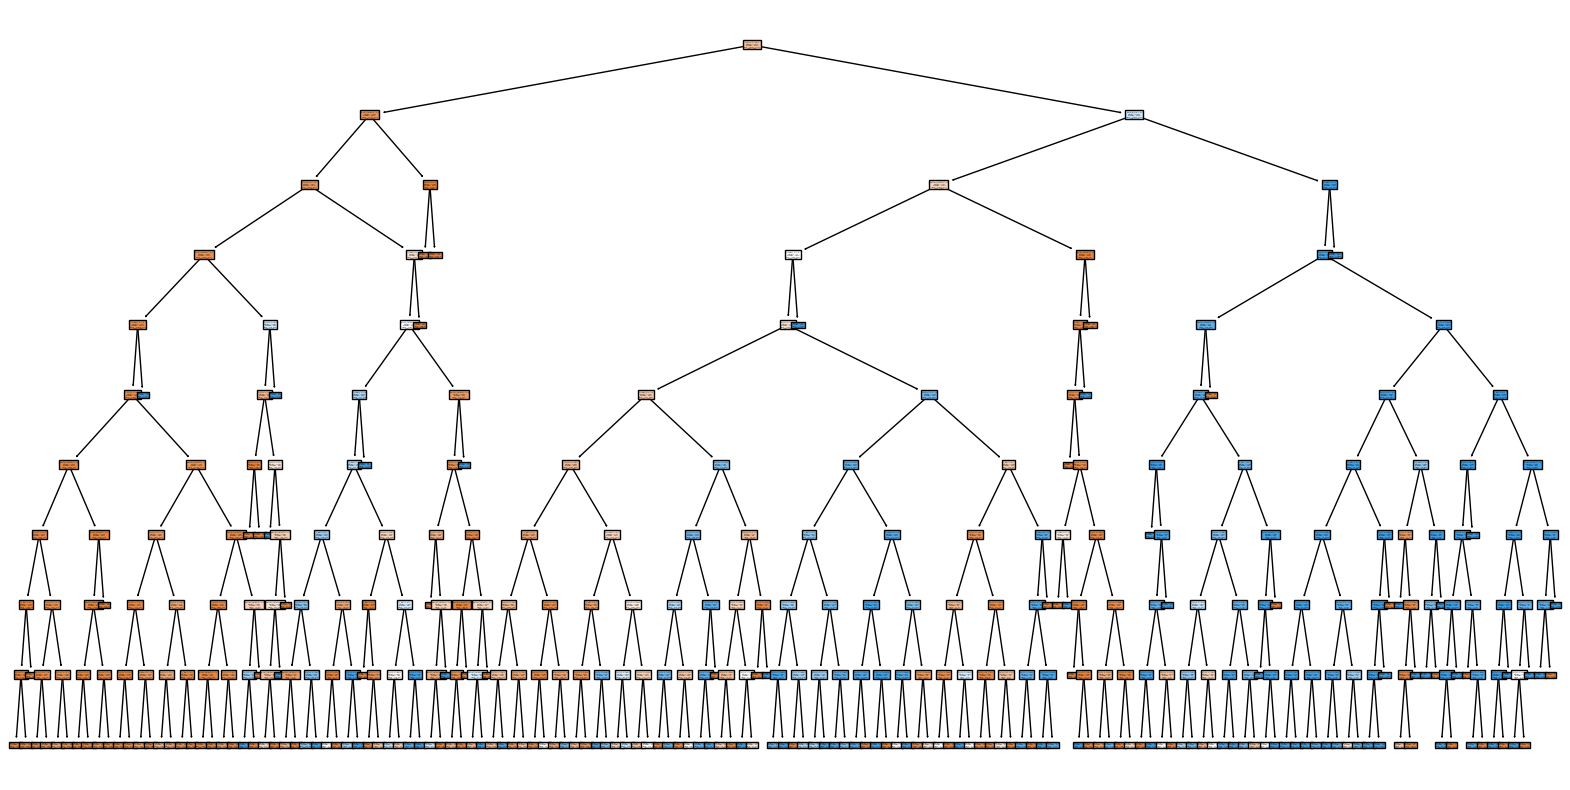

In [242]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=42)
clf = clf.fit(feature_df5, y_train)

# Visualize the decision tree
plt.figure(figsize=(20,10))  # Set the figure size for better readability
plot_tree(clf, filled=True, feature_names=feature_df5.columns.tolist(), class_names=['spam', 'ham'])
plt.show()


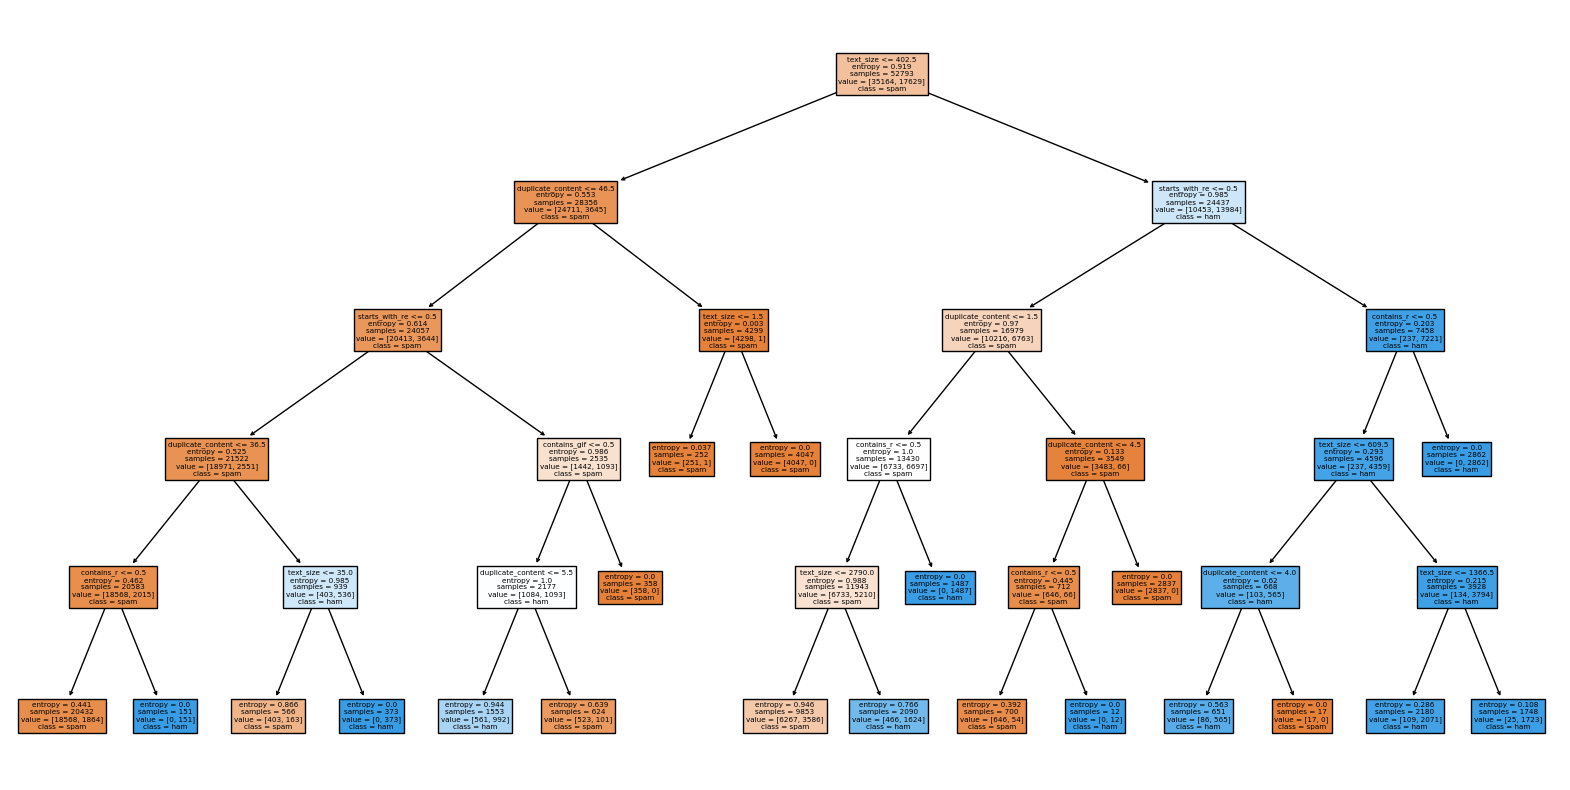

In [243]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=42)
clf = clf.fit(feature_df5, y_train)

# Visualize the decision tree
plt.figure(figsize=(20,10))  # Set the figure size for better readability
plot_tree(clf, filled=True, feature_names=feature_df5.columns.tolist(), class_names=['spam', 'ham'])
plt.show()


## 1-3. Ensemble (randomforest, adaboost, bagging)
## accuracy: 85.9%, 87.3%, 85.9%
### bagging은 train에서의 accuracy가 낮음

              precision    recall  f1-score   support

        Spam       0.88      0.91      0.90     15035
         Ham       0.82      0.75      0.78      7591

    accuracy                           0.86     22626
   macro avg       0.85      0.83      0.84     22626
weighted avg       0.86      0.86      0.86     22626

RandomForest_Classification accuracy 85.9%
              precision    recall  f1-score   support

        Spam       0.88      0.93      0.91     15035
         Ham       0.85      0.76      0.80      7591

    accuracy                           0.87     22626
   macro avg       0.87      0.84      0.85     22626
weighted avg       0.87      0.87      0.87     22626

Bagging_Classification accuracy 87.3%
              precision    recall  f1-score   support

        Spam       0.88      0.91      0.90     15035
         Ham       0.81      0.76      0.78      7591

    accuracy                           0.86     22626
   macro avg       0.84      0.83      0.84    

[Text(1.5, 0, 'Random Forest'),
 Text(2.5, 0, 'Bagging'),
 Text(3.5, 0, 'AdaBoost')]

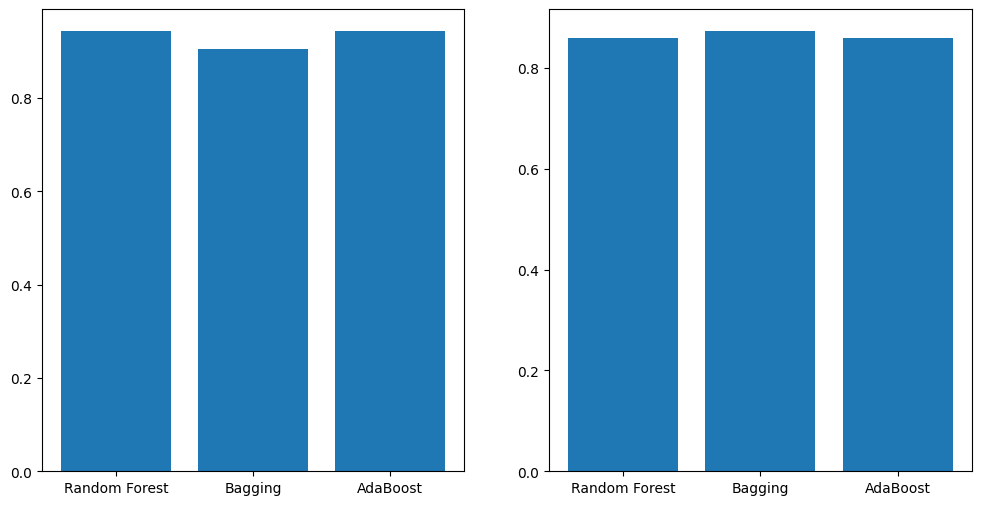

In [50]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

numBaseClassifiers = 500
maxdepth = 10
trainAcc = []
testAcc = []

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(feature_df5, y_train)
Y_predTrain = clf.predict(feature_df5)
Y_predTest = clf.predict(test_feature_df5)
trainAcc.append(accuracy_score(y_train, Y_predTrain))
testAcc.append(accuracy_score(y_test, Y_predTest))
print(classification_report(y_test,Y_predTest,target_names=['Spam','Ham']))
print('RandomForest_Classification accuracy {:.1%}'.format(accuracy_score(y_test,Y_predTest)))

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(feature_df5, y_train)
Y_predTrain = clf.predict(feature_df5)
Y_predTest = clf.predict(test_feature_df5)
trainAcc.append(accuracy_score(y_train, Y_predTrain))
testAcc.append(accuracy_score(y_test, Y_predTest))
print(classification_report(y_test,Y_predTest,target_names=['Spam','Ham']))
print('Bagging_Classification accuracy {:.1%}'.format(accuracy_score(y_test,Y_predTest)))

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(feature_df5, y_train)
Y_predTrain = clf.predict(feature_df5)
Y_predTest = clf.predict(test_feature_df5)
trainAcc.append(accuracy_score(y_train, Y_predTrain))
testAcc.append(accuracy_score(y_test, Y_predTest))
print(classification_report(y_test,Y_predTest,target_names=['Spam','Ham']))
print('AdaBoost_Classification accuracy {:.1%}'.format(accuracy_score(y_test,Y_predTest)))


methods = ['Random Forest', 'Bagging', 'AdaBoost']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5,3.5], trainAcc)
ax1.set_xticks([1.5,2.5,3.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5,2.5,3.5], testAcc)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)

## 1-4. XGBoost : accuracy: 87.5%

In [61]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize and train XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(feature_df5, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(test_feature_df5)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('XGBoost_Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))


              precision    recall  f1-score   support

        Spam       0.89      0.93      0.91     15035
         Ham       0.84      0.77      0.81      7591

    accuracy                           0.88     22626
   macro avg       0.87      0.85      0.86     22626
weighted avg       0.87      0.88      0.87     22626

XGBoost_Classification accuracy 87.5%


## 1-5. LightGBM accuracy: 87.7%

In [63]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score


# Initialize and train LightGBM
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(feature_df5, y_train)

# Predict and evaluate
y_pred = lgb_clf.predict(test_feature_df5, num_iteration=lgb_clf.best_iteration_)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred,target_names=['Spam','Ham']))
print('lightGBM_Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))


[LightGBM] [Info] Number of positive: 17629, number of negative: 35164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 52793, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333927 -> initscore=-0.690478
[LightGBM] [Info] Start training from score -0.690478
              precision    recall  f1-score   support

        Spam       0.89      0.93      0.91     15035
         Ham       0.85      0.77      0.81      7591

    accuracy                           0.88     22626
   macro avg       0.87      0.85      0.86     22626
weighted avg       0.88      0.88      0.88     22626

lightGBM_Classification accuracy 87.7%


## 1-6. KNN accuracy: 최대 83% 이하

Text(0, 0.5, 'Accuracy')

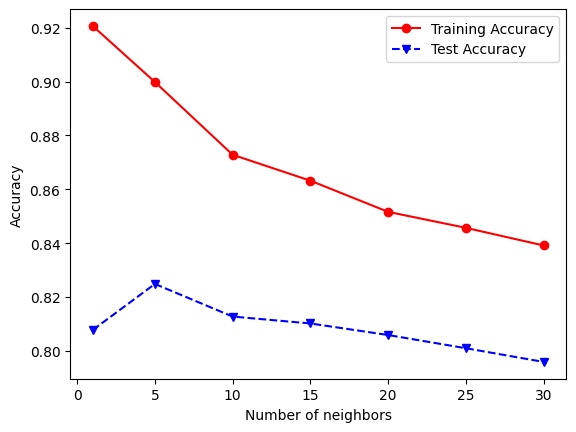

In [256]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

numNeighbors = [1, 5, 10, 15, 20, 25, 30]
trainAcc = []
testAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf.fit(feature_df5, y_train)
    Y_predTrain = clf.predict(feature_df5)
    Y_predTest = clf.predict(test_feature_df5)
    trainAcc.append(accuracy_score(y_train, Y_predTrain))
    testAcc.append(accuracy_score(y_test, Y_predTest))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

## 1-7. SVM (Non-linear) accuracy: 최대 77% 이하

Text(0, 0.5, 'Accuracy')

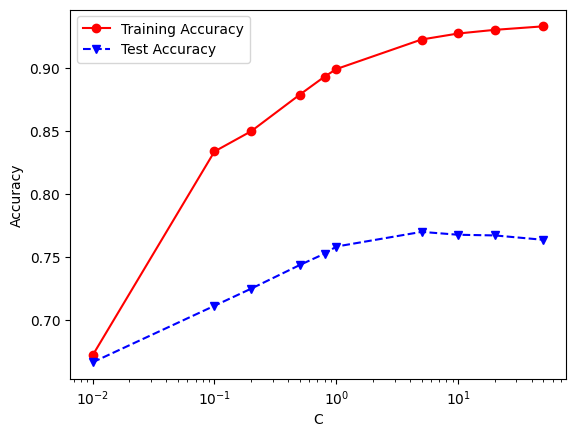

In [257]:
from sklearn.svm import SVC

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = SVC(C=param,kernel='rbf',gamma='auto')
    clf.fit(feature_df5, y_train)
    Y_predTrain = clf.predict(feature_df5)
    Y_predTest = clf.predict(test_feature_df5)
    SVMtrainAcc.append(accuracy_score(y_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(y_test, Y_predTest))

plt.plot(C, SVMtrainAcc, 'ro-', C, SVMtestAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

## 1-8. Logistic Regression accuracy: 84%, precision이 65%로 매우 낮음

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# Initialize and train classifier model
clf = LogisticRegression().fit(feature_df5, y_train)

# Make predictions on test set
y_pred = clf.predict(test_feature_df5)

# Compare test set predictions with ground truth labels
print(accuracy_score(y_pred, y_test))
print(precision_score(y_pred, y_test)) # tp / (tp + fp)
print(recall_score(y_pred, y_test)) # tp / (tp + fn)
print(f1_score(y_pred, y_test))
#print(precision_recall_fscore_support(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred)
cm1 = confusion_matrix(y_test, y_pred, normalize='true')
print(cm)
print("-----------------------")
print(cm1)

#___________________________________________________
#          |    normal         |     abnormal 
#--------------------------------------------------
# normal   |     12753         |       0           
#---------------------------------------------------
# abnormal |      0            |       190 
#---------------------------------------------------
#
# normal 을 normal 로 판정: True Positive 
# normal 을 abnormal 로 판정 : False Positive (오탐) 
# abnormal 을 normal 로 판정 : False Negative (미탐)
# abnormal 을 abnormal 로 판정: True Negative 


0.8437196146026695
0.6503754446054538
0.8484275648736896
0.7363161819537659
[[14153   882]
 [ 2654  4937]]
-----------------------
[[0.94133688 0.05866312]
 [0.34962456 0.65037544]]


C:\Users\jiyoo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


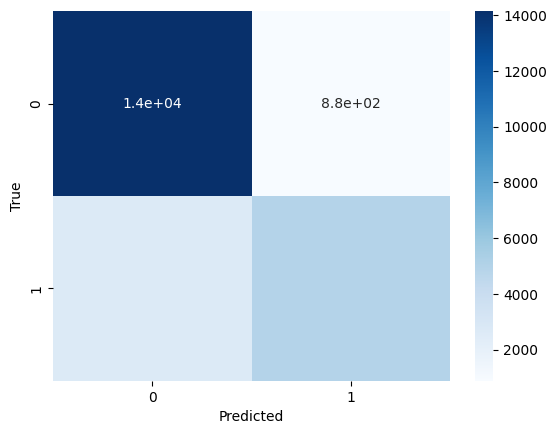

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 1-9. Stacking (random forest, xgb, lgb): 높은 accuracy가 나온 분류기를 혼합해서 사용
## 그럼에도 87.6% 정도로 성능 개선 실패

In [59]:
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb

# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier())
]

# Initialize Stacking Classifier with Logistic Regression as the final estimator
stack_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=5)

# Train stacked model
stack_clf.fit(feature_df5, y_train)

# Predict and evaluate
y_pred = stack_clf.predict(test_feature_df5)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {accuracy}")


C:\Users\jiyoo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jiyoo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 17629, number of negative: 35164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 52793, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333927 -> initscore=-0.690478
[LightGBM] [Info] Start training from score -0.690478
[LightGBM] [Info] Number of positive: 14103, number of negative: 28131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 42234, number of used features: 13
[LightGBM] [Info] [b